# Support Vector Machine (SVM) - From Scratch (Hard-Margin)
  
**Goal:** Implement a hard-margin SVM **from scratch** via the Lagrange-dual with gradient ascent, validate on a simple 2D dataset, compare with scikit-learn, and create visuals.



## 1. About this Sprint

### Sprint Objective
- Understand SVM **from scratch**
- Get exposure to linear models and kernelized variants
- Learn by **implementing - training - validation**

In [ ]:
# Imports & setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# scikit-learn for dataset & metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC

np.random.seed(42)

# Matplotlib defaults/preferences
plt.rcParams["figure.figsize"] = (7.5, 5.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

## 2. SVM Scratch - Class Implementation


In [ ]:
class ScratchSVMClassifier:
    """
    Scratch hard-margin SVM classifier (binary) using dual gradient ascent.

    Parameters
    ----------
    num_iter : int
        Number of dual ascent iterations.
    lr : float
        Learning rate for λ updates.
    kernel : str
        "linear" or "poly".
    threshold : float
        Threshold to select support vectors from λ.
    verbose : bool
        If True, prints progress.
    gamma : float
        Polynomial kernel γ (ignored for linear).
    coef0 : float
        Polynomial kernel θ0 (ignored for linear).
    degree : int
        Polynomial kernel degree d (ignored for linear).
    use_bias : bool
        If True, compute intercept b from margin SVs for prediction.

    Attributes
    ----------
    n_support_vectors : int
        Number of support vectors.
    index_support_vectors : ndarray of shape (n_sv,)
        Indices of support vectors in the training set.
    X_sv : ndarray of shape (n_sv, n_features)
        Support vector features.
    lam_sv : ndarray of shape (n_sv,)
        Lagrange multipliers for support vectors.
    y_sv : ndarray of shape (n_sv,)
        Labels (-1/+1) for support vectors.
    b_ : float
        Intercept term used in prediction (0 if use_bias=False or not computed).
    history_dual : ndarray of shape (num_iter,)
        Dual objective value per iteration.
    history_eq_resid : ndarray of shape (num_iter,)
        Equality constraint residual |sum(λ_i y_i)| per iteration.
    """
    def __init__(self, num_iter=1000, lr=0.1, kernel='linear', threshold=1e-5, verbose=False,
                 gamma=1.0, coef0=0.0, degree=1, use_bias=True):
        self.iter = int(num_iter)
        self.lr = float(lr)
        self.kernel = kernel
        self.threshold = float(threshold)
        self.verbose = bool(verbose)
        self.gamma = float(gamma)
        self.coef0 = float(coef0)
        self.degree = int(degree)
        self.use_bias = bool(use_bias)

        # Learned state
        self.lam_ = None
        self.X_train_ = None
        self.y_train_ = None  # stored as -1/+1
        self.K_ = None        # kernel matrix
        self.b_ = 0.0

        # Support vectors
        self.n_support_vectors = 0
        self.index_support_vectors = None
        self.X_sv = None
        self.lam_sv = None
        self.y_sv = None

        # Tracking
        self.history_dual = None
        self.history_eq_resid = None

    # Kernel utilities
    def _kernel(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        """Compute kernel matrix between row-sets A (m,d) and B (n,d)."""
        if self.kernel == 'linear':
            return A @ B.T
        elif self.kernel == 'poly':
            return (self.gamma * (A @ B.T) + self.coef0) ** self.degree
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")

    def _compute_kernel_matrix(self, X: np.ndarray) -> np.ndarray:
        return self._kernel(X, X)

    # Problem 1: Steepest Descent - Lagrange Multiplier
    def _update_lambdas(self):
        """
        Update λ using the gradient of the dual:
            g_i = 1 - sum_j λ_j y_i y_j k(x_i, x_j)
        Vectorized: g = 1 - y * (K @ (λ ∘ y)).
        Then project λ to satisfy λ >= 0 and approximately enforce sum_i λ_i y_i = 0.
        """
        y = self.y_train_
        lam = self.lam_
        Ky = self.K_ @ (lam * y)          # shape (N,)
        grad = 1.0 - y * Ky               # shape (N,)
        lam_new = lam + self.lr * grad

        # Project to λ >= 0
        lam_new = np.maximum(lam_new, 0.0)

        # Enforce equality constraint sum_i λ_i y_i = 0 by a simple projection
        eq = np.sum(lam_new * y)
        if abs(eq) > 1e-12:
            # Since y_i ∈ {-1,+1}, denominator is N for subtracting average along y
            N = len(y)
            lam_new = lam_new - (eq / N) * y
            lam_new = np.maximum(lam_new, 0.0)  # keep nonnegative after projection

        self.lam_ = lam_new

    # Dual objective for tracking
    def _dual_objective(self) -> float:
        lam = self.lam_
        y = self.y_train_
        term1 = np.sum(lam)
        term2 = 0.5 * np.sum((lam[:, None] * lam[None, :]) * (y[:, None] * y[None, :]) * self.K_)
        return float(term1 - term2)

    # Problem 2: Select support vectors
    def _select_support_vectors(self):
        idx = np.where(self.lam_ > self.threshold)[0]
        self.index_support_vectors = idx
        self.n_support_vectors = len(idx)
        self.X_sv = self.X_train_[idx]
        self.lam_sv = self.lam_[idx]
        self.y_sv = self.y_train_[idx]

    # Compute intercept b using margin SVs (optional)
    def _compute_intercept(self):
        if not self.use_bias or self.n_support_vectors == 0:
            self.b_ = 0.0
            return
        # For each SV i: b_i = y_i - sum_j λ_j y_j k(x_i, x_j); average over SVs.
        K_sv = self._kernel(self.X_sv, self.X_train_)
        b_each = self.y_sv - (self.lam_ * self.y_train_)[None, :] @ K_sv.T
        b_each = b_each.reshape(-1)
        self.b_ = float(np.mean(b_each))

    # Fit
    def fit(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray = None, y_val: np.ndarray = None):
        """
        Train the hard-margin SVM via dual gradient ascent.
        y can be {0,1} or {-1,+1}; internally converted to {-1,+1}.
        """
        X = np.asarray(X, dtype=float)
        y = np.asarray(y).reshape(-1)
        y_unique = np.unique(y)
        if set(y_unique.tolist()) == {0,1}:
            y = np.where(y == 1, 1.0, -1.0)
        else:
            y = y.astype(float)

        N = X.shape[0]
        self.X_train_ = X.copy()
        self.y_train_ = y.copy()
        self.lam_ = np.zeros(N, dtype=float)
        self.K_ = self._compute_kernel_matrix(X)

        self.history_dual = np.zeros(self.iter, dtype=float)
        self.history_eq_resid = np.zeros(self.iter, dtype=float)

        for t in range(self.iter):
            self._update_lambdas()
            # Track objective & equality residual
            self.history_dual[t] = self._dual_objective()
            self.history_eq_resid[t] = abs(np.sum(self.lam_ * self.y_train_))

            if self.verbose and (t % max(1, self.iter//10) == 0 or t == self.iter-1):
                print(f"iter {t+1:4d}/{self.iter}  dual={self.history_dual[t]:.6f}  |Σλy|={self.history_eq_resid[t]:.3e}")

        # Support vectors
        self._select_support_vectors()
        # Intercept
        self._compute_intercept()
        return self

    # Problem 3: Prediction
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        if self.n_support_vectors == 0:
            # fallback: use all points if SVs not selected yet
            K = self._kernel(X, self.X_train_)
            score = (self.lam_ * self.y_train_)[None, :] @ K.T
            return score.reshape(-1) + self.b_
        K = self._kernel(X, self.X_sv)
        score = (self.lam_sv * self.y_sv)[None, :] @ K.T
        return score.reshape(-1) + self.b_

    def predict(self, X: np.ndarray) -> np.ndarray:
        score = self.decision_function(X)
        y_hat_pm = np.sign(score)
        y_hat_pm[y_hat_pm == 0] = 1  # tie-break
        # Map back to {0,1}
        return ((y_hat_pm + 1) / 2).astype(int)

## 3. Verification (Problem 4) - Learning & Estimation on "Iris Dataset"


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

SKLEARN_AVAILABLE = True
try:
    from sklearn.datasets import fetch_openml
except ImportError:
    SKLEARN_AVAILABLE = False

# 1) Load Iris (binary: versicolor vs. virginica) with two features
def load_iris_binary(feature_idx=(1, 2)):
    """
    feature_idx:
        0: sepal length, 1: sepal width, 2: petal length, 3: petal width
    Returns: X (n,2), y01 (n,) in {0,1}, feat_names (list[str])
    """
    iris = load_iris()
    X_all = iris.data[:, feature_idx]
    y_all = iris.target  # 0=setosa, 1=versicolor, 2=virginica

    mask = (y_all != 0)              # keep versicolor & virginica only
    X = X_all[mask]
    y01 = (y_all[mask] == 2).astype(int)  # versicolor=0, virginica=1
    feat_names = [iris.feature_names[i] for i in feature_idx]
    return X, y01, feat_names

# Use sepal width (x) and petal length (y)
X, y01, feat_names = load_iris_binary((1, 2))
print("Iris binary shape:", X.shape, "features:", feat_names)

# 2) Stratified split
X_train, X_val, y_train01, y_val01 = train_test_split(
    X, y01, test_size=0.30, stratify=y01, random_state=42
)

# 3) Standardize features (helps gradient steps)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)

# 4) Map labels to {-1,+1} for the scratch dual, then train
y_train_pm = np.where(y_train01 == 1, 1, -1)  # +1 = virginica, -1 = versicolor
y_val_pm   = np.where(y_val01   == 1, 1, -1)

svm_lin = ScratchSVMClassifier(
    num_iter=5000, lr=0.01, kernel='linear',
    threshold=1e-6, verbose=False, use_bias=True
)
svm_lin.fit(X_train_s, y_train_pm)

# 5) Predict with scratch model (returns ±1) → convert back to {0,1}
pred_val_pm = svm_lin.predict(X_val_s)
pred_val    = (pred_val_pm == 1).astype(int)

# 6) Metrics (binary: positive=1=virginica)
acc  = accuracy_score(y_val01, pred_val)
prec = precision_score(y_val01, pred_val, zero_division=0)
rec  = recall_score(y_val01, pred_val, zero_division=0)

print("Scratch SVM (linear) — Validation")
print("  Accuracy :", f"{acc:.4f}")
print("  Precision:", f"{prec:.4f}")
print("  Recall   :", f"{rec:.4f}")


n_sv = getattr(svm_lin, "n_support_vectors", None)
if n_sv is not None:
    print("  #Support vectors:", n_sv)

# 7) Baseline: scikit-learn SVC (same standardized features)
svc = SVC(C=1e6, kernel='linear', random_state=42)
svc.fit(X_train_s, y_train01)
pred_val_svc = svc.predict(X_val_s)
acc2  = accuracy_score(y_val01, pred_val_svc)
prec2 = precision_score(y_val01, pred_val_svc, zero_division=0)
rec2  = recall_score(y_val01, pred_val_svc, zero_division=0)

print("\nscikit-learn SVC (linear, hard-margin-ish) — Validation")
print("  Accuracy :", f"{acc2:.4f}")
print("  Precision:", f"{prec2:.4f}")
print("  Recall   :", f"{rec2:.4f}")

Iris binary shape: (100, 2) features: ['sepal width (cm)', 'petal length (cm)']
Scratch SVM (linear) — Validation
  Accuracy : 0.8000
  Precision: 0.7368
  Recall   : 0.9333
  #Support vectors: 46

scikit-learn SVC (linear, hard-margin-ish) — Validation
  Accuracy : 0.9000
  Precision: 0.8750
  Recall   : 0.9333


The Sci-kit Learn (Baseline) Models has the better performance than our scratch model

### Convergence Diagnostics


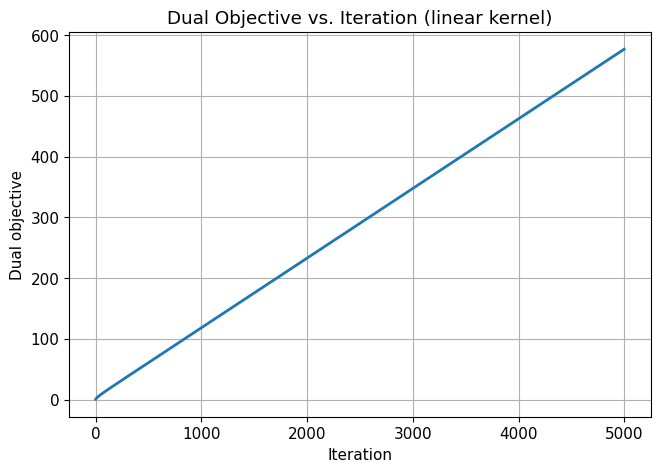

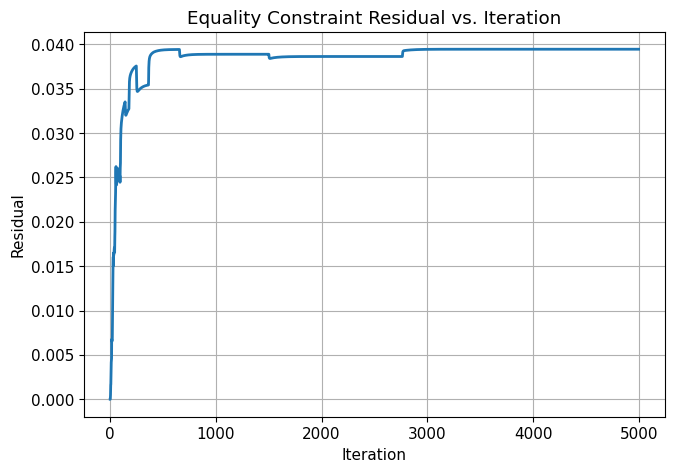

In [ ]:
fig = plt.figure()
plt.plot(svm_lin.history_dual, linewidth=2.0)
plt.xlabel("Iteration")
plt.ylabel("Dual objective")
plt.title("Dual Objective vs. Iteration (linear kernel)")
plt.show()

fig = plt.figure()
plt.plot(svm_lin.history_eq_resid, linewidth=2.0)
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.title("Equality Constraint Residual vs. Iteration")
plt.show()

## Problem 5 - Decision Regions

We plot decision regions in 2D. Support vectors are shown with a distinct marker edge.


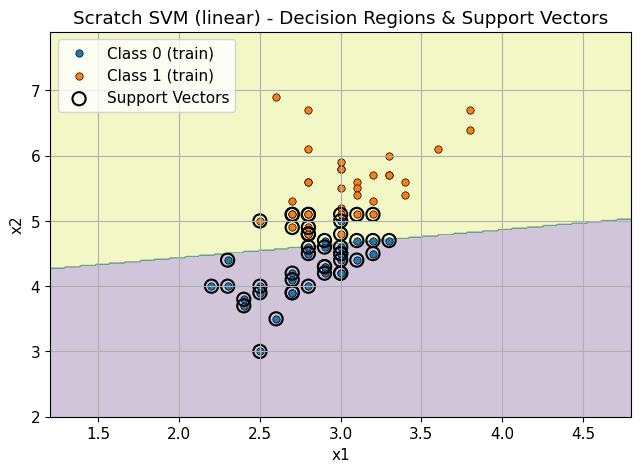

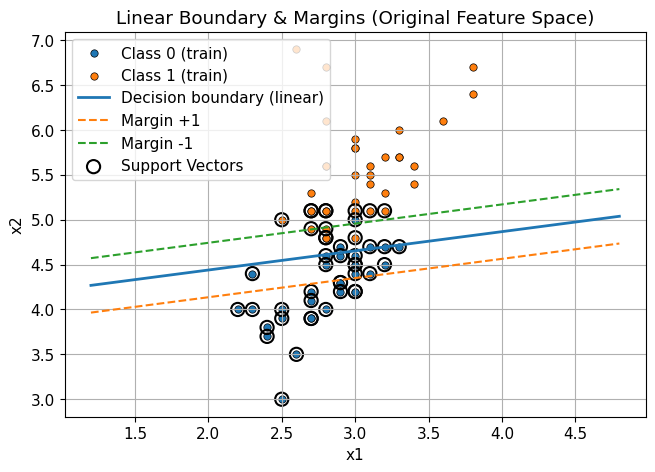

In [ ]:
# Decision region helper (plots in ORIGINAL feature space)
def plot_decision_regions(model: ScratchSVMClassifier, X_train_orig, y_train01, scaler=None, title="Decision Regions"):
    """
    model: trained ScratchSVMClassifier (fit on SCALED features, labels in {-1,+1})
    X_train_orig: training features in ORIGINAL units (before scaling), shape (n, 2)
    y_train01: training labels in {0,1} used only for coloring the scatter
    scaler: fitted StandardScaler used during training (so we can transform the grid before predict)
    """
    # Bounds from original space
    x_min, x_max = X_train_orig[:,0].min() - 1.0, X_train_orig[:,0].max() + 1.0
    y_min, y_max = X_train_orig[:,1].min() - 1.0, X_train_orig[:,1].max() + 1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid_orig = np.c_[xx.ravel(), yy.ravel()]

    # Transform grid to scaled space if a scaler was used for training
    if scaler is not None:
        grid_scaled = scaler.transform(grid_orig)
    else:
        grid_scaled = grid_orig

    # Model predicts in ±1; reshape to grid
    Z_pm = model.predict(grid_scaled).reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z_pm, alpha=0.25)

    # Training points (original space), colored by {0,1}
    plt.scatter(X_train_orig[y_train01==0,0], X_train_orig[y_train01==0,1],
                s=28, edgecolor="k", linewidth=0.5, label="Class 0 (train)")
    plt.scatter(X_train_orig[y_train01==1,0], X_train_orig[y_train01==1,1],
                s=28, edgecolor="k", linewidth=0.5, label="Class 1 (train)")

    # Support vectors highlighted (convert from scaled back to original for plotting)
    sv = getattr(model, "index_support_vectors", None)
    if sv is not None and len(sv) > 0:
        sv_scaled = model.X_train_[sv]  # these are in scaled space
        sv_orig = scaler.inverse_transform(sv_scaled) if scaler is not None else sv_scaled
        plt.scatter(sv_orig[:,0], sv_orig[:,1], s=90, facecolors='none',
                    edgecolors='k', linewidth=1.5, label="Support Vectors")

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.show()

# Use original (unscaled) training features and {0,1} labels for coloring
plot_decision_regions(svm_lin, X_train, y_train01,
                      scaler=scaler,
                      title="Scratch SVM (linear) - Decision Regions & Support Vectors")

# If linear kernel: plot separating line and margins in ORIGINAL feature space
if getattr(svm_lin, "kernel", None) == 'linear':
    # w_z, b_z are in the SCALED space used for training:
    #   w_z = sum_i λ_i y_i x_i_scaled
    lam = svm_lin.lam_
    y_pm_train = svm_lin.y_train_          # ±1 labels used in training
    X_train_scaled = svm_lin.X_train_      # scaled training features used in training
    w_z = (lam * y_pm_train) @ X_train_scaled   # shape (2,)
    b_z = svm_lin.b_

    # Map linear boundary back to ORIGINAL space:
    # If z = (x - mu)/sigma, then w_x = w_z / sigma and b_x = b_z - w_z·(mu/sigma)
    if scaler is not None:
        sigma = scaler.scale_
        mu = scaler.mean_
        w_x = w_z / sigma
        b_x = b_z - np.dot(w_z, mu / sigma)
    else:
        w_x = w_z
        b_x = b_z

    # Plot line y = -(w1/w2) x - b/w2 and margins at ±1 (all in ORIGINAL space)
    if abs(w_x[1]) > 1e-12:
        xs = np.linspace(X_train[:,0].min() - 1.0, X_train[:,0].max() + 1.0, 200)
        ys = -(w_x[0]/w_x[1]) * xs - b_x / w_x[1]

        fig = plt.figure()
        plt.scatter(X_train[y_train01==0,0], X_train[y_train01==0,1],
                    s=28, edgecolor="k", linewidth=0.5, label="Class 0 (train)")
        plt.scatter(X_train[y_train01==1,0], X_train[y_train01==1,1],
                    s=28, edgecolor="k", linewidth=0.5, label="Class 1 (train)")
        plt.plot(xs, ys, linewidth=2.0, label="Decision boundary (linear)")

        # Margins: w_x · x + b_x = ±1  ⇒  y = -(w1/w2)x - (b_x ± 1)/w2
        ys_m1 = -(w_x[0]/w_x[1]) * xs - (b_x + 1.0) / w_x[1]
        ys_p1 = -(w_x[0]/w_x[1]) * xs - (b_x - 1.0) / w_x[1]
        plt.plot(xs, ys_m1, linestyle="--", linewidth=1.5, label="Margin +1")
        plt.plot(xs, ys_p1, linestyle="--", linewidth=1.5, label="Margin -1")

        # Support vectors in ORIGINAL space
        sv = getattr(svm_lin, "index_support_vectors", None)
        if sv is not None and len(sv) > 0:
            sv_scaled = svm_lin.X_train_[sv]
            sv_orig = scaler.inverse_transform(sv_scaled) if scaler is not None else sv_scaled
            plt.scatter(sv_orig[:,0], sv_orig[:,1], s=90, facecolors='none',
                        edgecolors='k', linewidth=1.5, label="Support Vectors")

        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Linear Boundary & Margins (Original Feature Space)")
        plt.legend()
        plt.show()

## Problem 6 - Polynomial Kernel



Scratch SVM (poly) - Validation
  Accuracy : 0.4667
  Precision: 0.4615
  Recall   : 0.4000

scikit-learn SVC (poly) - Validation
  Accuracy : 0.9000
  Precision: 1.0000
  Recall   : 0.8000


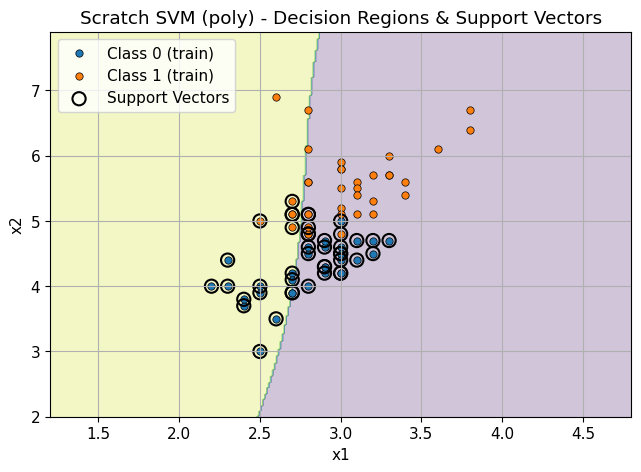

In [ ]:
# Train a polynomial-kernel SVM (SCRATCH) on SCALED features, ±1 labels
svm_poly = ScratchSVMClassifier(
    num_iter=3000, lr=0.01, kernel='poly',
    gamma=0.8, coef0=1.0, degree=3,
    threshold=1e-6, verbose=False, use_bias=True
)
svm_poly.fit(X_train_s, y_train_pm)

# Predict (returns ±1) -> map back to {0,1}
pred_val_poly_pm = svm_poly.predict(X_val_s)
pred_val_poly    = (pred_val_poly_pm == 1).astype(int)

# Metrics (binary: positive=1=virginica)
accp  = accuracy_score(y_val01, pred_val_poly)
precp = precision_score(y_val01, pred_val_poly, zero_division=0)
recp  = recall_score(y_val01, pred_val_poly, zero_division=0)

print("Scratch SVM (poly) - Validation")
print("  Accuracy :", f"{accp:.4f}")
print("  Precision:", f"{precp:.4f}")
print("  Recall   :", f"{recp:.4f}")

# Baseline: scikit-learn SVC with polynomial kernel (on SCALED features, {0,1} labels) ---
svc_poly = SVC(C=1e6, kernel='poly', gamma=0.8, coef0=1.0, degree=3, random_state=42)
svc_poly.fit(X_train_s, y_train01)
pred_svc_poly = svc_poly.predict(X_val_s)

accp2  = accuracy_score(y_val01, pred_svc_poly)
precp2 = precision_score(y_val01, pred_svc_poly, zero_division=0)
recp2  = recall_score(y_val01, pred_svc_poly, zero_division=0)

print("\nscikit-learn SVC (poly) - Validation")
print("  Accuracy :", f"{accp2:.4f}")
print("  Precision:", f"{precp2:.4f}")
print("  Recall   :", f"{recp2:.4f}")

# --- Decision regions for polynomial model (plot in ORIGINAL feature space) ---
def plot_decision_regions_poly(model: ScratchSVMClassifier,
                               X_train_orig, y_train01,
                               scaler=None,
                               title="Scratch SVM (poly) - Decision Regions & Support Vectors"):
    # Bounds from original space
    x_min, x_max = X_train_orig[:,0].min() - 1.0, X_train_orig[:,0].max() + 1.0
    y_min, y_max = X_train_orig[:,1].min() - 1.0, X_train_orig[:,1].max() + 1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid_orig = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid_orig) if scaler is not None else grid_orig

    # Scratch model predicts in ±1
    Z_pm = model.predict(grid_scaled).reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z_pm, alpha=0.25)
    plt.scatter(X_train_orig[y_train01==0,0], X_train_orig[y_train01==0,1],
                s=28, edgecolor="k", linewidth=0.5, label="Class 0 (train)")
    plt.scatter(X_train_orig[y_train01==1,0], X_train_orig[y_train01==1,1],
                s=28, edgecolor="k", linewidth=0.5, label="Class 1 (train)")

    # Highlight support vectors (convert scaled -> original for plotting)
    sv = getattr(model, "index_support_vectors", None)
    if sv is not None and len(sv) > 0:
        sv_scaled = model.X_train_[sv]  # stored in scaled space
        sv_orig = scaler.inverse_transform(sv_scaled) if scaler is not None else sv_scaled
        plt.scatter(sv_orig[:,0], sv_orig[:,1], s=90, facecolors='none',
                    edgecolors='k', linewidth=1.5, label="Support Vectors")

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.show()

# Call with ORIGINAL training features + {0,1} labels and the fitted scaler
plot_decision_regions_poly(svm_poly, X_train, y_train01, scaler=scaler)


---

## Conclusions

- This notebook addresses all requested items:
- Quite the challenge